#### Import Libraries

In [1]:
import pandas as pd # data wrangling
import tensorflow as tf # deep learning
import numpy as np # math
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # data viz 1
import seaborn as sns # data viz 2
import statistics

#### Import data

In [2]:
complaints_df = pd.read_csv('complaints-2019-06-29_08_09.csv', usecols = ['Product', 'Complaint ID', 'Consumer complaint narrative'])
complaints_df.drop_duplicates(inplace=True)
print("Dataframe's shape", complaints_df.shape)
print("Unique # of Complaints", len(complaints_df['Complaint ID'].unique()))

Dataframe's shape (144319, 3)
Unique # of Complaints 144319


In [3]:
complaints_df.Product.value_counts().head()

Credit reporting, credit repair services, or other personal consumer reports    59944
Debt collection                                                                 31538
Credit card or prepaid card                                                     14483
Mortgage                                                                        12475
Checking or savings account                                                      8676
Name: Product, dtype: int64

In [4]:
complaints_df['is_debt_collection'] = np.where(complaints_df['Product']=='Debt collection', 1, 0)

In [5]:
complaints_df.is_debt_collection.value_counts()

0    112781
1     31538
Name: is_debt_collection, dtype: int64

In [6]:
train_df, test_df = train_test_split(complaints_df, test_size = 0.3)

In [7]:
tokenizer_ks = keras.preprocessing.text.Tokenizer(num_words=6000, filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

In [8]:
tokenizer_ks.fit_on_texts(train_df['Consumer complaint narrative'])

In [9]:
print(tokenizer_ks.texts_to_sequences(["i was charged extra $"])) 

[[3, 11, 255, 942, 503]]


In [10]:
train_vec = tokenizer_ks.texts_to_sequences(train_df['Consumer complaint narrative'])
test_vec  = tokenizer_ks.texts_to_sequences(test_df['Consumer complaint narrative'])

In [11]:
lengths = [len(i) for i in train_vec]

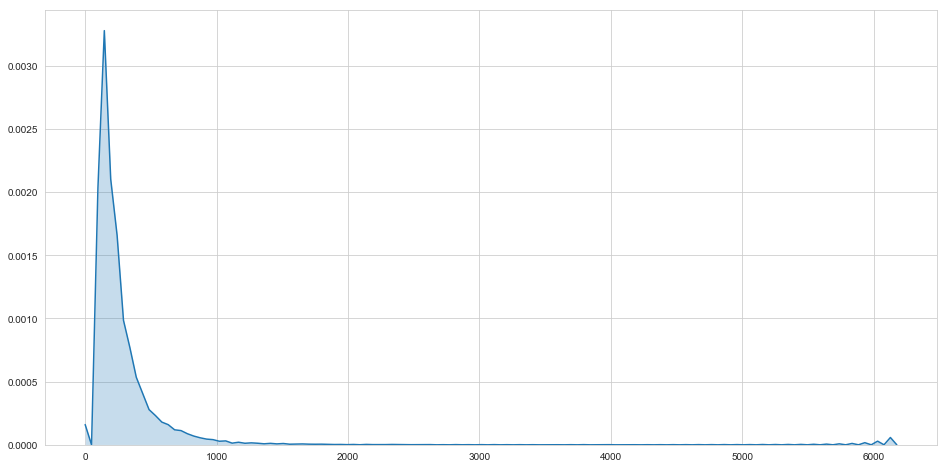

In [12]:
plt.figure(figsize=(16, 8))
sns.set_style('whitegrid')
sns.kdeplot(np.array(lengths), bw=0.5, shade=True)

In [13]:
train_data = keras.preprocessing.sequence.pad_sequences(train_vec,
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_vec,
                                                       padding='post',
                                                       maxlen=256)

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer_ks.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [15]:
decode_review(train_data[0])

"i started attending xxxx xxxx in xx xx 2009 i went a year without any problems then i went through some life changing problems and had to stop for a short time about a month or two when i went to re enroll they had canceled my program xxxx xxxx and could no longer get a associates in that area of so i switched programs but they just were not for me now i have all this debt no degree and credits that nobody wants i'm stuck and very upset about it no one wants to work with me on out a solution other than asking for the loan payback while attending the college they were unprofessional and it seemed like they just wanted you to just through the what i mean is it seemed like they just passed you no matter if you learned the or not just to get you out of there i feel like i learned nothing from this college other than how to spend a ton of money while getting absolutely nothing in return i was ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 

In [16]:
decode_review(train_vec[0])

"i started attending xxxx xxxx in xx xx 2009 i went a year without any problems then i went through some life changing problems and had to stop for a short time about a month or two when i went to re enroll they had canceled my program xxxx xxxx and could no longer get a associates in that area of so i switched programs but they just were not for me now i have all this debt no degree and credits that nobody wants i'm stuck and very upset about it no one wants to work with me on out a solution other than asking for the loan payback while attending the college they were unprofessional and it seemed like they just wanted you to just through the what i mean is it seemed like they just passed you no matter if you learned the or not just to get you out of there i feel like i learned nothing from this college other than how to spend a ton of money while getting absolutely nothing in return i was"

In [17]:
# input shape is the vocabulary count used for the complaint data (6000 words)
vocab_size = 6000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          96000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 96,289
Trainable params: 96,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_df.is_debt_collection[:10000]
partial_y_train = train_df.is_debt_collection[10000:]

In [ ]:
x_val.shape

(10000, 256)

In [ ]:
partial_x_train.shape

(91023, 256)

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 91023 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
91023/91023 [==============================] - 6s 64us/sample - loss: 0.5590 - acc: 0.7811 - val_loss: 0.4982 - val_acc: 0.7822
Epoch 2/40
91023/91023 [==============================] - 5s 56us/sample - loss: 0.4656 - acc: 0.7831 - val_loss: 0.4127 - val_acc: 0.7957
Epoch 3/40
91023/91023 [==============================] - 5s 55us/sample - loss: 0.3393 - acc: 0.8491 - val_loss: 0.2903 - val_acc: 0.8819
Epoch 4/40
91023/91023 [==============================] - 5s 57us/sample - loss: 0.2720 - acc: 0.8928 - val_loss: 0.2669 - val_acc: 0.8970
Epoch 5/40
91023/91023 [==============================] - 6s 69us/sample - loss: 0.2550 - acc: 0.9011 - val_loss: 0.2586 - val_acc: 0.8943
Epoch 6/40
91023/91023 [==============================] - 7s 72us/sample - loss: 0.2456 - acc: 0.9054 - val_loss: 0.2514 - val_acc: 0.9028
Epoch 7/40
91023/91023 [==============================] - 6s 66us/sa

In [ ]:
results = model.evaluate(test_data, test_df.is_debt_collection)

print(results)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()